In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [ ]:


from tensorflow.keras.layers import Dense, Flatten, Reshape

input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(512, activation='relu')(x)  # Latent space

# Classifier head
classifier_output = Dense(10, activation='softmax', name='class_output')(encoded)

# Decoder
x = Dense(2048, activation='relu')(encoded)
x = Reshape((4, 4, 128))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='recon_output')(x)

# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


In [58]:
autoencoder = Model(inputs=input_img, outputs=[decoded, classifier_output])

autoencoder.compile(
    optimizer='adam',
    loss={'recon_output': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'recon_output': 'mse', 'class_output': 'accuracy'}
)

# Then train with both outputs
autoencoder.fit(
    x_train,
    {'recon_output': x_train, 'class_output': y_train_cat},
    validation_data=(x_test, {'recon_output': x_test, 'class_output': y_test_cat}),
    epochs=30,
    batch_size=256,
    shuffle=True
)


Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 107s 520ms/step - class_output_accuracy: 0.3089 - class_output_loss: 1.8854 - loss: 1.9379 - recon_output_loss: 0.0524 - recon_output_mse: 0.0524 - val_class_output_accuracy: 0.5223 - val_class_output_loss: 1.3278 - val_loss: 1.3635 - val_recon_output_loss: 0.0326 - val_recon_output_mse: 0.0325
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 97s 497ms/step - class_output_accuracy: 0.5778 - class_output_loss: 1.1920 - loss: 1.2213 - recon_output_loss: 0.0293 - recon_output_mse: 0.0293 - val_class_output_accuracy: 0.6184 - val_class_output_loss: 1.0837 - val_loss: 1.1080 - val_recon_output_loss: 0.0252 - val_recon_output_mse: 0.0251
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 94s 477ms/step - class_output_accuracy: 0.6592 - class_output_loss: 0.9820 - loss: 1.0060 - recon_output_loss: 0.0240 - recon_output_mse: 0.0240 - val_class_output_accuracy: 0.6561 - val_class_output_loss: 0.9821 - val_loss: 1.0059 - val_recon_output_loss: 0.0218 - val_recon_output_mse: 0

In [59]:
# Define encoder model for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)
encoded_imgs = encoder.predict(x_train)

# Flatten encoded features
flattened = encoded_imgs.reshape(len(encoded_imgs), -1)

# Apply KMeans to flattened features
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(flattened)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [60]:
from sklearn.metrics import silhouette_score

# Evaluate clustering performance
sil_score = silhouette_score(encoded_imgs, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0024


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


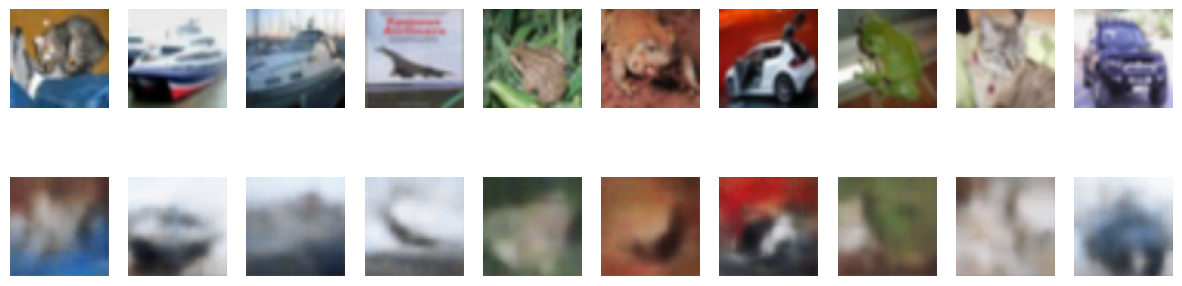

In [61]:
# Plot original and reconstructed images

import matplotlib.pyplot as plt

# Get reconstructed images (taking only the reconstruction output [0])
decoded_imgs = autoencoder.predict(x_test[:10])[0]

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x_test[i])  # Original
    axes[1, i].imshow(decoded_imgs[i])  # Reconstructed
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()


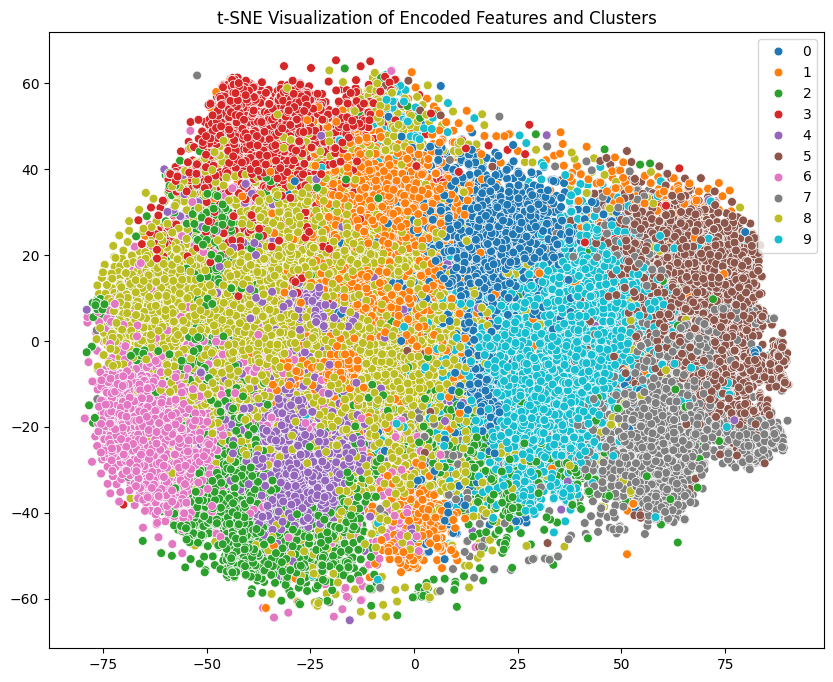

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(flattened)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=cluster_labels, palette="tab10", s=40)
plt.title("t-SNE Visualization of Encoded Features and Clusters")
plt.show()


In [63]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()

# Get reconstructions
decoded_imgs = autoencoder.predict(x_test)

# Calculate average MSE over the whole test set
loss = mse(x_test, decoded_imgs).numpy()

print(f"Average MSE on test set: {loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


ValueError: Structures don't have the same nested structure.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reduce before clustering
encoded_pca = PCA(n_components=50).fit_transform(encoded_features)
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(encoded_pca)
score = silhouette_score(encoded_pca, labels)


NameError: name 'encoded_features' is not defined